In [ ]:
import pandas as pd
from typing import Optional, List, Tuple
import os

os.environ['TOKENIZERS_PARALLELISM'] = 'false' # do not use multiprocessing to avoid the paralelism problem
pd.set_option("display.max_colwidth", None)  # this will be helpful when visualizing retriever outputs

### 0. Load dataset

In [ ]:
from langchain.document_loaders import UnstructuredFileLoader

RAW_KNOWLEDGE_BASE = UnstructuredFileLoader("./docs/hobbitultrashort.txt").load()

### 1. Retriever - embeddings
<p>The retriever acts like an internal search engine: given the user query, it returns a few relevant snippets from your knowledge base. These snippets will then be fed to the Reader Model to help it generate its answer.</p>

#### 1.1 Split the documents into chunks

<i>Many options exist for text splitting: splitting on words, on sentence boundaries, recursive chunking that processes documents in a tree-like way to preserve structure information…</i>

- <b>Recursive chunking</b> breaks down the text into smaller parts step by step using a given list of separators sorted from the most important to the least important separator. <br>
For instance with the list of separators ["\n\n", "\n", ".", ""]

We also keep in mind that before we split the documents into chuncks we have to embed the documents and it could be a problem that the chunk lengths are not aligned with our limit maximum sequence length of the embedding model. </br>
<b>So we should make sure that our chunck sizes are below this limit, because any longer chunk will be trucated before processing, thus losing relevancy.</b>

In [ ]:
from sentence_transformers import SentenceTransformer

EMBED_MODEL_NAME = 'thenlper/gte-small'

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter: 512.
print(f"Model's maximum sequence length: {SentenceTransformer(EMBED_MODEL_NAME).max_seq_length}")

Now that we already know the maximum length of the embedding model we can create a RecursiveCharacterTextSplitter to count length in number of tokens instead of number of characters and then we can choose specific chunck size. To do that we indicate in the splitter the tokenizer we will use.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from langchain.docstore.document import Document as LangchainDocument

# This list is taken from LangChain's MarkdownTextSplitter class.
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

def split_documents(chunk_size: int, knowledge_base: List[LangchainDocument], tokenizer_name: Optional[str] = EMBED_MODEL_NAME, ) -> List[LangchainDocument]:
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name), # we use the same tokenizer model as the embedding model
        chunk_size=chunk_size,  # the maximum number of characters in a chunk: we selected this value arbitrarily
        chunk_overlap=int(chunk_size/10),  # the number of characters to overlap between chunks
        add_start_index=True,  # If `True`, includes chunk's start index in metadata
        strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBED_MODEL_NAME,
)

#### 1.2 Building the vector database
We want to compute the embeddings for all the chunks of our knowledge base.</br> We first convert the chunks tokenized into embeddings.

##### Distances
We will use <b>Cosine similarity</b>. <br> It computes similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions are regardless of their magnitude. Using it requires to normalize all vectors, to rescale them into unit norm.

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBED_MODEL_NAME,
    multi_process=True, 
    model_kwargs={"device": "mps"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

#### 1.3 Create Chroma vector store
🚨👇 The cell below takes a few minutes to run!

In [ ]:
from langchain.vectorstores import Chroma

KNOWLEDGE_VECTOR_DATABASE = Chroma.from_documents(documents=docs_processed, embedding=embedding_model, persist_directory="./chromaultrashort")

#### 1.4 Load Chroma vector store

In [ ]:
from langchain.vectorstores import Chroma

KNOWLEDGE_VECTOR_DATABASE = Chroma(persist_directory="./chromaultrashorthobbit", embedding_function=embedding_model)

#### 1.5 Evaluate similarity
To evaluate and graphically display the similarity between the vector of your question and the vectors returned, you can use the concept of vector similarity measures such as cosine similarity. Here's a simple example using Python and the NumPy library. This code calculates the cosine similarity between the question vector and the returned vectors, then displays the similarity as a percentage. It also visualizes the vectors as arrows in a 2D plot and in a 3D plot.

##### 1.5.1 Evaluate similarity **for more than one question**


Starting retrieval for user_query='What is a hobbit?'...

==================================Top document==================================
The mother of our particular hobbit — what is a hobbit? I suppose hobbits need some description nowadays, since they have become rare and shy of the Big People, as they call us. They are (or were) a little people, about half our height, and smaller than the bearded Dwarves. Hobbits have no beards. There is little or no magic about them, except the ordinary everyday sort which helps them to disappear quietly and quickly when large stupid folk like you and me come blundering along, making a noise like elephants which they can hear a mile off. They are inclined to be fat in the stomach; they dress in bright colours (chiefly green and yellow); wear no shoes, because their feet grow natural leathery soles and thick warm brown hair like the stuff on their heads (which is curly); have long clever brown fingers, good-natured faces, and laugh deep fruity la

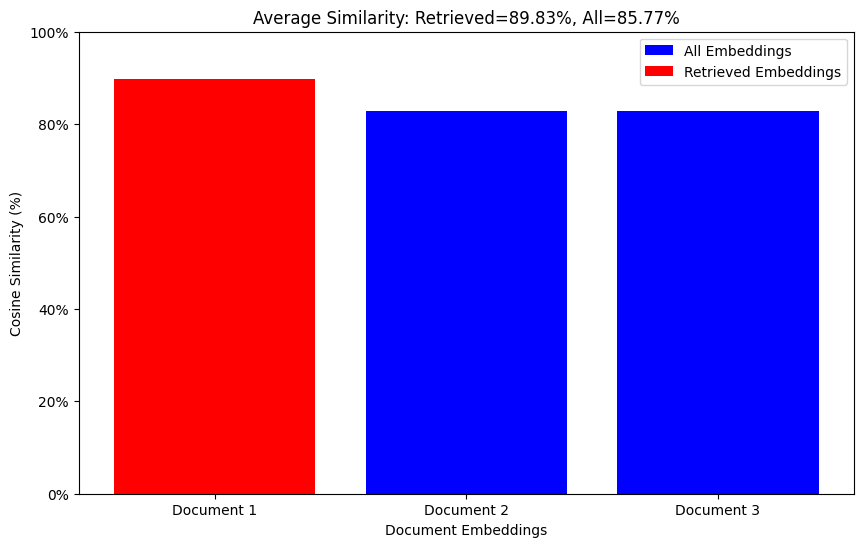


Starting retrieval for user_query='¿Cómo se describe la casa del protagonista?'...

==================================Top document==================================
In a hole in the ground there lived a hobbit. Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell, nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat: it was a hobbit-hole, and that means comfort.

It had a perfectly round door like a porthole, painted green, with a shiny yellow brass knob in the exact middle. The door opened on to a tube-shaped hall like a tunnel: a very comfortable tunnel without smoke, with panelled walls, and floors tiled and carpeted, provided with polished chairs, and lots and lots of pegs for hats and coats — the hobbit was fond of visitors. The tunnel wound on and on, going fairly but not quite straight into the side of the hill — The Hill, as all the people for many miles round called it — and many little round doors opened out of it, first on one

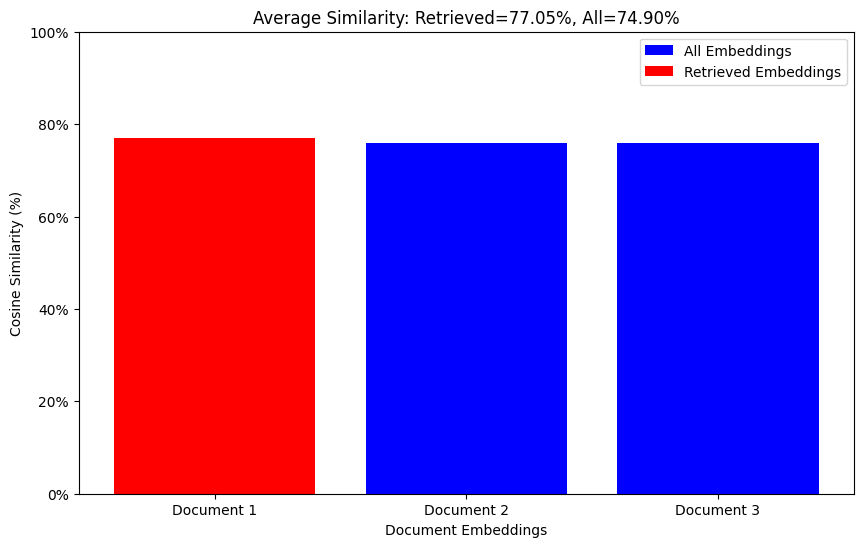


Starting retrieval for user_query='What is said about the reputation of the Baggins family?'...

==================================Top document==================================
that the Tooks were not as respectable as the Bagginses, though they were undoubtedly richer.

Not that Belladonna Took ever had any adventures after she became Mrs. Bungo Baggins. Bungo, that was Bilbo’s father, built the most luxurious hobbit-hole for her (and partly with her money) that was to be found either under The Hill or over The Hill or across The Water, and there they remained to the end of their days. Still it is probable that Bilbo, her only son, although he looked and behaved exactly like a second edition of his solid and comfortable father, got something a bit queer in his make-up from the Took side, something that only waited for a chance to come out. The chance never arrived, until Bilbo Baggins was grown up, being about fifty years old or so, and living in the beautiful hobbit-hole built by h

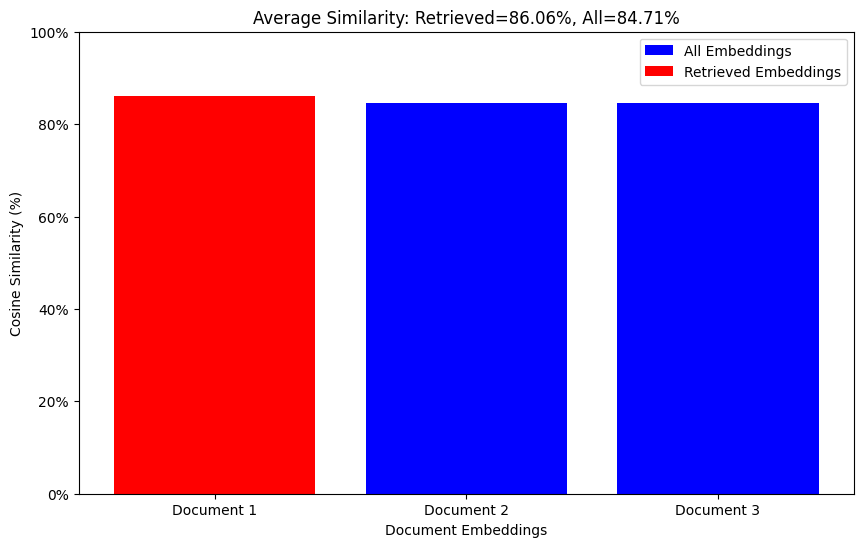


Starting retrieval for user_query='¿Qué características físicas y culturales distinguen a los hobbits según el texto?'...

==================================Top document==================================
The mother of our particular hobbit — what is a hobbit? I suppose hobbits need some description nowadays, since they have become rare and shy of the Big People, as they call us. They are (or were) a little people, about half our height, and smaller than the bearded Dwarves. Hobbits have no beards. There is little or no magic about them, except the ordinary everyday sort which helps them to disappear quietly and quickly when large stupid folk like you and me come blundering along, making a noise like elephants which they can hear a mile off. They are inclined to be fat in the stomach; they dress in bright colours (chiefly green and yellow); wear no shoes, because their feet grow natural leathery soles and thick warm brown hair like the stuff on their heads (which is curly); have long c

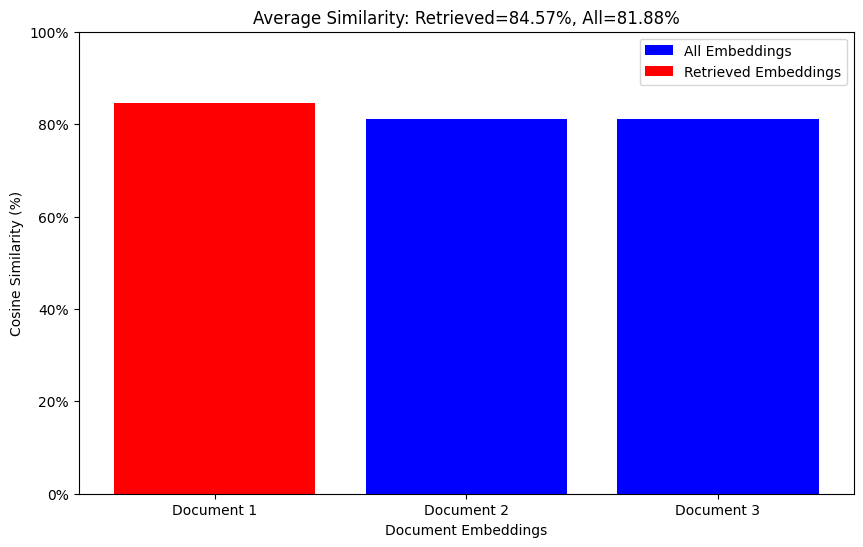

In [65]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

user_queries = ["What is a hobbit?", "¿Cómo se describe la casa del protagonista?", "What is said about the reputation of the Baggins family?", "¿Qué características físicas y culturales distinguen a los hobbits según el texto?"]
queries_vectors = [embedding_model.embed_query(user_query) for user_query in user_queries]

# Load all embeddings from the local Chroma vector store
chroma_return = KNOWLEDGE_VECTOR_DATABASE.get(include=['embeddings'])
chroma_embeds = chroma_return['embeddings']

cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)

for i, user_query in enumerate(user_queries):
    print(f"\nStarting retrieval for {user_query=}...")
    retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=1)

    print("\n==================================Top document==================================")
    print(retrieved_docs[0].page_content)
    print("==================================Metadata top document==================================")
    print(retrieved_docs[0].metadata)
    print("==================================All documents==================================")
    for doc in retrieved_docs:
        print(doc.metadata)


    # Show results
    retrieved_embeddings = [embedding_model.embed_query(doc.page_content) for doc in retrieved_docs]

    similarities = []
    for embedding in chroma_embeds:
        if embedding not in retrieved_embeddings:
            output = cos(torch.tensor(queries_vectors[i]), torch.tensor(embedding))
            similarities.append(output.item())

    retrieved_similarities = []
    for embedding in retrieved_embeddings:
        output = cos(torch.tensor(queries_vectors[i]), torch.tensor(embedding))
        retrieved_similarities.append(output.item())

    # Calculate the average similarity of all embeddings in the vector store
    avg_similarity = np.mean(similarities)

    # Calculate the average similarity of the retrieved embeddings
    retrieved_avg_similarity = np.mean(retrieved_similarities)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(1, len(chroma_embeds)+1), [s*100 for s in similarities[len(retrieved_similarities):]], label="All Embeddings", color='b')
    ax.bar(range(1, len(retrieved_similarities)+1), [s*100 for s in retrieved_similarities], label="Retrieved Embeddings", color='r')
    ax.set_xlabel("Document Embeddings")
    ax.set_ylabel("Cosine Similarity (%)")
    ax.set_title(f"Average Similarity: Retrieved={retrieved_avg_similarity*100:.2f}%, All={avg_similarity*100:.2f}%")
    ax.set_xticks(range(1, len(chroma_embeds)+1))
    ax.set_xticklabels([f"Document {i}" for i in range(1, len(chroma_embeds)+1)])
    ax.legend()

    # Set y-axis limits to 0 and 100
    plt.ylim(0, 100)

    # Format y-axis ticks as integers
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d%%'))
    plt.show()


##### 1.5.2 Evaluate similarity **for one question**

In [55]:
from langchain.vectorstores import Chroma

# embed a user query in the same space
user_query = "What is a hobbit?"
query_vector = embedding_model.embed_query(user_query)

print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=1)

print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata top document==================================")
print(retrieved_docs[0].metadata)
print("==================================All documents==================================")
for doc in retrieved_docs:
    print(doc.metadata)


Starting retrieval for user_query='What is a hobbit?'...

==================================Top document==================================
The mother of our particular hobbit — what is a hobbit? I suppose hobbits need some description nowadays, since they have become rare and shy of the Big People, as they call us. They are (or were) a little people, about half our height, and smaller than the bearded Dwarves. Hobbits have no beards. There is little or no magic about them, except the ordinary everyday sort which helps them to disappear quietly and quickly when large stupid folk like you and me come blundering along, making a noise like elephants which they can hear a mile off. They are inclined to be fat in the stomach; they dress in bright colours (chiefly green and yellow); wear no shoes, because their feet grow natural leathery soles and thick warm brown hair like the stuff on their heads (which is curly); have long clever brown fingers, good-natured faces, and laugh deep fruity la

**Show results** <br><br>
It calculates the cosine similarity between the user's question and each retrieved embedding. Finally, it plots the similarities and displays the average similarity for both the retrieved embeddings and all embeddings in the vector store as a percentage.

In [56]:
import numpy as np
import torch

# Load all embeddings from the local Chroma vector store
chroma_return = KNOWLEDGE_VECTOR_DATABASE.get(include=['embeddings'])
chroma_embeds = chroma_return['embeddings']

# Convert the retrieved documents to embeddings
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=1)
retrieved_embeddings = [embedding_model.embed_query(doc.page_content) for doc in retrieved_docs]

cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)

# Calculate the cosine similarity between the user's question and all embeddings in the vector store
similarities = []
for embedding in chroma_embeds:
    if embedding not in retrieved_embeddings:
        output = cos(torch.tensor(query_vector), torch.tensor(embedding))
        similarities.append(output.item())

retrieved_similarities = []
for embedding in retrieved_embeddings:
    output = cos(torch.tensor(query_vector), torch.tensor(embedding))
    retrieved_similarities.append(output.item())

# Calculate the average similarity of all embeddings in the vector store
avg_similarity = np.mean(similarities)

# Calculate the average similarity of the retrieved embeddings
retrieved_avg_similarity = np.mean(retrieved_similarities)

**Plot results** <br><br>
*Plot the results into a graphic type bar*

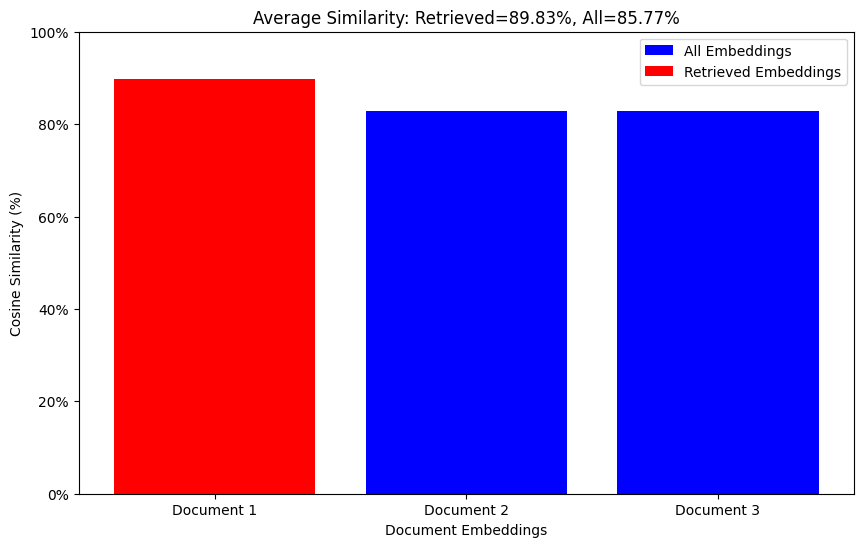

In [57]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(1, len(chroma_embeds)+1), [s*100 for s in similarities[len(retrieved_similarities):]], label="All Embeddings", color='b')
ax.bar(range(1, len(retrieved_similarities)+1), [s*100 for s in retrieved_similarities], label="Retrieved Embeddings", color='r')
ax.set_xlabel("Document Embeddings")
ax.set_ylabel("Cosine Similarity (%)")
ax.set_title(f"Average Similarity: Retrieved={retrieved_avg_similarity*100:.2f}%, All={avg_similarity*100:.2f}%")
ax.set_xticks(range(1, len(chroma_embeds)+1))
ax.set_xticklabels([f"Document {i}" for i in range(1, len(chroma_embeds)+1)])
ax.legend()

# Set y-axis limits to 0 and 100
plt.ylim(0, 100)

# Format y-axis ticks as integers
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d%%'))
plt.show()

*Plot the results into a graphic 3D point*

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all the vectors
ax.scatter([embedding[0] for embedding in chroma_embeds], [embedding[1] for embedding in chroma_embeds], [embedding[2] for embedding in chroma_embeds], c='gray', alpha=0.5, label='All Embeddings')
ax.scatter([embedding[0] for embedding in retrieved_embeddings], [embedding[1] for embedding in retrieved_embeddings], [embedding[2] for embedding in retrieved_embeddings], c='red', alpha=1.0, label='Retrieved Embeddings')
ax.scatter(query_vector[0], query_vector[1], query_vector[2], c='blue', alpha=1.0, label='Question Vector')

# Set the plot labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the plot title
ax.set_title(f"Average Similarity: Retrieved={retrieved_avg_similarity*100:.2f}%, All={avg_similarity*100:.2f}%")

# Set the legend
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Set the tick labels for the x, y, and z axes
ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
ax.zaxis.set_major_locator(ticker.MaxNLocator(3))

# Show the plot
plt.show()

### 2. Reader - LLM
The LLM Reader reads the retrieved context (the content of the retrieved documents) to formulate its answer. <br>
The context and the user query are aggregated into a prompt then given to the LLM to generate its answer.

#### 2.1. Reader model
<b>The reader model’s max_seq_length must accomodate our prompt</b> , which includes the context output by the retriever call: the context consists in 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.<br><br>

In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

#### 2.2. Prompt
The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM’s chat template.<br><br>

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

#### 2.3. Reranking
A good option for RAG is to retrieve more documents than you want in the end, then rerank the results with a more powerful retrieval model before keeping only the top_k.<br><br>

In [ ]:
from ragatouille import RAGPretrainedModel
from transformers import Pipeline

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: Chroma,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)